In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import random
import numpy as np
import yfinance as yf # ticker data
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy
import time

In [94]:
from database import DatabaseUBCTG
db = DatabaseUBCTG()
df = db.get_returns_universe(start="2022-01-01", end="2022-12-31")
print(df)

         Permno Ticker        Date   Returns
0         10026   JJSF  2022-01-03  0.007344
1         10026   JJSF  2022-01-04 -0.003582
2         10026   JJSF  2022-01-05 -0.003406
3         10026   JJSF  2022-01-06 -0.000316
4         10026   JJSF  2022-01-07  0.004052
...         ...    ...         ...       ...
2391745   93436   TSLA  2022-12-23 -0.017551
2391746   93436   TSLA  2022-12-27 -0.114089
2391747   93436   TSLA  2022-12-28  0.033089
2391748   93436   TSLA  2022-12-29  0.080827
2391749   93436   TSLA  2022-12-30  0.011164

[2391750 rows x 4 columns]


In [4]:
# Convert the date column to datetime if it's not already
# df['Date'] = pd.to_datetime(df['Date'])

# Filter out rows before January 1, 2022
# filtered_df = df[df['Date'] >= '2022-01-01']
# Filter out rows that don't have data from December 30, 2022
# filtered_df = df[df['Date'] == '2022-12-30']

In [6]:
unique_tickers = df['Ticker'].unique()
print((unique_tickers))
print(len(unique_tickers))

['JJSF' 'ELA' 'PLXS' ... 'CBOE' 'SANW' 'TSLA']
10285


In [7]:
# Convert the date column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Create a mask for tickers with 0 or NaN values between Jan 1, 2022, and Dec 30, 2022\n",
mask = ((df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-30')) & (df.isin([np.nan]).any(axis=1))

# Get tickers to filter out
tickers_to_filter = df[mask]['Ticker'].unique()

# Filter the DataFrame to exclude rows with tickers having NaN values
filtered_df = df[~df['Ticker'].isin(tickers_to_filter)]

In [10]:
print(tickers_to_filter)
print(len(tickers_to_filter))

['RSXJ' None 'AMPE' 'YNDX' 'AREN' 'PME' 'QIWI' 'BLUE' 'AAMC' 'TMBR' 'MESO'
 'EVTV' 'ONE' 'BBIG' 'HHR' 'CCAC' 'OPT' 'OZON' 'BTMD' 'AFAQ' 'PLL' 'GDEV'
 'ARBK' 'AHI' 'CIAN' 'RESI' 'HOTL' 'TPG' 'FGI' 'CRDO' 'CEG' 'ALOR' 'ALSA'
 'AMLX' 'APCX' 'APXI' 'AZ' 'BIOS' 'BLEU' 'BOCN' 'BPAC' 'BRFH' 'BRKH'
 'CFSB' 'CINC' 'CISO' 'CMCA' 'CNGL' 'CREC' 'DAOO' 'DCFC' 'DMAT' 'ENCP'
 'FEXD' 'FXCO' 'GDNR' 'GEEX' 'GFGD' 'GGAA' 'HAIA' 'HILS' 'HORI' 'HOUR'
 'IDAI' 'IGTA' 'IOAC' 'JWAC' 'KACL' 'KSCP' 'LFAC' 'LGST' 'MAAQ' 'NSTS'
 'NVAC' 'NZRO' 'OLIT' 'RNER' 'ROCL' 'SATL' 'TCHI' 'TGAA' 'TKLF' 'TLGY'
 'UMMA' 'UTAA' 'VHNA' 'VIGL' 'VMGA' 'WTMA' 'XDNA' 'XPDB' 'ZING' 'SAMT'
 'SAGP' 'SIXJ' 'AVSC' 'ATEK' 'BRD' 'CWC' 'FLTN' 'RSEE' 'TRDF' 'DMA' 'EVEN'
 'ONG' 'FNTC' 'WEIX' 'SEA' 'MNTN' 'BNGE' 'GAST' 'XDJA' 'XTJA' 'XBJA'
 'QTJA' 'IRRX' 'RJAC' 'JBBB' 'FLDZ' 'NETC' 'IUSA' 'PAXS' 'PACI' 'REMG'
 'RDMX' 'ESIX' 'PUNK' 'SUAC' 'EAFD' 'EMGD' 'RTYD' 'PORT' 'UPAR' 'TCOA'
 'VZLA' 'IFIN' 'NFNT' 'WEL' 'MTVC' 'SCUA' 'STET' 'SGHC' 'ZIMV' 'ACL

In [32]:
print(filtered_df)

         Permno Ticker       Date   Returns
0         10026   JJSF 2022-01-03  0.007344
1         10026   JJSF 2022-01-04 -0.003582
2         10026   JJSF 2022-01-05 -0.003406
3         10026   JJSF 2022-01-06 -0.000316
4         10026   JJSF 2022-01-07  0.004052
...         ...    ...        ...       ...
2391745   93436   TSLA 2022-12-23 -0.017551
2391746   93436   TSLA 2022-12-27 -0.114089
2391747   93436   TSLA 2022-12-28  0.033089
2391748   93436   TSLA 2022-12-29  0.080827
2391749   93436   TSLA 2022-12-30  0.011164

[2261755 rows x 4 columns]


In [72]:
# Convert the date column to datetime if it's not already
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Use pivot_table with aggregation (mean) to handle duplicates
pivot_df = filtered_df.pivot_table(index='Date', columns='Ticker', values='Returns', aggfunc='mean')

# Remove columns (companies) with remaining NaN values
pivot_df = pivot_df_filled.dropna(axis=1)

print(pivot_df)

C:\Users\joshl\AppData\Local\Temp/ipykernel_27520/3719724649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])


Ticker             A        AA      AAAU       AAC      AACG      AACI  \
Date                                                                     
2022-01-03 -0.018541  0.013092 -0.014851  0.002053  0.111630  0.012257   
2022-01-04 -0.033806 -0.046885  0.007817  0.002049  1.142857 -0.001009   
2022-01-05 -0.017131  0.017730 -0.002770  0.001022 -0.098039 -0.005051   
2022-01-06  0.003499 -0.001708 -0.012778 -0.003064 -0.139130 -0.005076   
2022-01-07 -0.026623  0.067066  0.005065  0.001025  0.333333  0.007143   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  0.001476  0.007982  0.003093 -0.000992 -0.006897  0.001992   
2022-12-27  0.002144  0.014932  0.008410  0.001986 -0.055556  0.000000   
2022-12-28 -0.009763 -0.023629 -0.004726 -0.000991 -0.039044  0.003976   
2022-12-29  0.020258  0.063014  0.005866  0.000992  0.032979  0.007921   
2022-12-30 -0.008042 -0.023411  0.004721 -0.001982 -0.056815 -0.005894   

Ticker          AADI      AADR      A

In [83]:
print(type(pivot_df))

<class 'pandas.core.frame.DataFrame'>


In [84]:
matrix_data_trial = pivot_df.values
print(matrix_data_trial)

[[-0.018541  0.013092 -0.014851 ...  0.035998  0.048611  0.032096]
 [-0.033806 -0.046885  0.007817 ... -0.045936 -0.023179 -0.025267]
 [-0.017131  0.01773  -0.00277  ... -0.067901 -0.091525  0.02991 ]
 ...
 [-0.009763 -0.023629 -0.004726 ...  0.        0.0314    0.008721]
 [ 0.020258  0.063014  0.005866 ...  0.042724  0.099283 -0.00072 ]
 [-0.008042 -0.023411  0.004721 ...  0.006402 -0.065091  0.002884]]


In [85]:
# matrix_data[day][ticker]
print(matrix_data_trial[-1][-4])

-0.030261


In [95]:
# Function that does everything above:
def convert(df):
    unique_tickers = df['Ticker'].unique()
    
    # Convert the date column to datetime if it's not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Create a mask for tickers with 0 or NaN values between Jan 1, 2022, and Dec 30, 2022\n",
    mask = ((df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-30')) & (df.isin([np.nan]).any(axis=1))

    # Get tickers to filter out
    tickers_to_filter = df[mask]['Ticker'].unique()

    # Filter the DataFrame to exclude rows with tickers having NaN values
    filtered_df = df[~df['Ticker'].isin(tickers_to_filter)]
    
    # Convert the date column to datetime if it's not already
    filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

    # Use pivot_table with aggregation (mean) to handle duplicates
    pivot_df = filtered_df.pivot_table(index='Date', columns='Ticker', values='Returns', aggfunc='mean')

    # Remove columns (companies) with remaining NaN values
    pivot_df = pivot_df_filled.dropna(axis=1)

    matrix_data = pivot_df.values

    return matrix_data

In [96]:
matrix_data = convert(df)
print(matrix_data)

C:\Users\joshl\AppData\Local\Temp/ipykernel_27520/365102903.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])


[[-0.018541  0.013092 -0.014851 ...  0.035998  0.048611  0.032096]
 [-0.033806 -0.046885  0.007817 ... -0.045936 -0.023179 -0.025267]
 [-0.017131  0.01773  -0.00277  ... -0.067901 -0.091525  0.02991 ]
 ...
 [-0.009763 -0.023629 -0.004726 ...  0.        0.0314    0.008721]
 [ 0.020258  0.063014  0.005866 ...  0.042724  0.099283 -0.00072 ]
 [-0.008042 -0.023411  0.004721 ...  0.006402 -0.065091  0.002884]]


In [76]:
weight = np.full((8515, 1), 1/8515)
print(weight)

[[0.00011744]
 [0.00011744]
 [0.00011744]
 ...
 [0.00011744]
 [0.00011744]
 [0.00011744]]


In [77]:
print(len(weight))
print(len(weight[0]))

8515
1


In [98]:
portfolio_returns = np.dot(matrix_data, weight)
print(portfolio_returns)

[[ 1.24580776e-02]
 [-3.45274909e-03]
 [-2.28573758e-02]
 [-8.36200646e-04]
 [-3.54695232e-03]
 [-5.90316835e-03]
 [ 1.28674329e-02]
 [-1.63022789e-03]
 [-1.17816709e-02]
 [-6.39383030e-04]
 [-2.06636648e-02]
 [-7.57907980e-03]
 [-1.07067293e-02]
 [-2.06633955e-02]
 [ 2.22691022e-03]
 [-4.39567346e-03]
 [-8.91327821e-03]
 [-1.67384965e-02]
 [ 1.29040876e-02]
 [ 3.02243721e-02]
 [ 1.28846129e-02]
 [-8.30826935e-03]
 [-1.78460527e-02]
 [ 7.57919530e-03]
 [ 4.12461715e-03]
 [ 8.61502366e-03]
 [ 1.69349957e-02]
 [-1.08757787e-02]
 [-1.15955479e-02]
 [-7.96546806e-03]
 [ 2.14873537e-02]
 [ 1.69572513e-03]
 [-1.85868985e-02]
 [-9.76860476e-03]
 [-1.42428988e-02]
 [-1.37887348e-02]
 [ 1.43687069e-02]
 [ 1.71939637e-02]
 [ 2.86790681e-03]
 [-1.09191042e-02]
 [ 1.33017400e-02]
 [-1.13580798e-02]
 [-1.36469596e-02]
 [-1.82601737e-02]
 [ 5.72710523e-03]
 [ 2.37616517e-02]
 [-4.60653682e-03]
 [-1.62190223e-02]
 [-2.13955882e-02]
 [ 1.09967019e-02]
 [ 3.15237763e-02]
 [ 1.87147711e-02]
 [ 1.3141985

In [105]:
print(type(portfolio_returns))
print(len(portfolio_returns))
print(len(portfolio_returns[0]))

<class 'numpy.ndarray'>
251
1


In [125]:
def calculate_ES(returns):
    # Flatten the 2D array to a 1D array
    returns = returns.flatten()

    # Set the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the expected shortfall
    es = np.percentile(returns, q=(1 - confidence_level) * 100)
    average_loss = np.mean(returns[returns <= es])

    print(f"Expected Shortfall (ES) at {confidence_level * 100}% confidence level: {es:.4f}")
    print(f"Average Loss Beyond ES: {average_loss:.4f}")

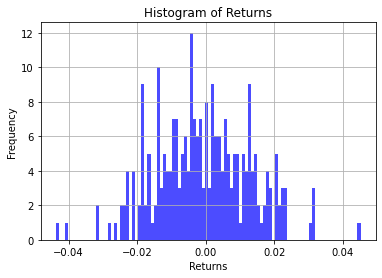

In [126]:
# Plot the histogram
plt.hist(portfolio_returns, bins=100, color='blue', alpha=0.7)
plt.title('Histogram of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [127]:
calculate_ES(portfolio_returns)

Expected Shortfall (ES) at 95.0% confidence level: -0.0228
Average Loss Beyond ES: -0.0282
